In [11]:
### INSTALL PICASO
!which pip
!pip install virga-exo==0.3.4
!pip install picaso==3.1.2

/Users/xqchen/workspace/doppler-imaging-maxentropy/venv/bin/pip
  Using cached virga_exo-0.3.4-py3-none-any.whl.metadata (877 bytes)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.0/59.0 kB 2.1 MB/s eta 0:00:00
  Attempting uninstall: virga-exo
    Found existing installation: virga-exo 0.4
    Uninstalling virga-exo-0.4:
      Successfully uninstalled virga-exo-0.4


In [1]:
import os
homedir = os.path.expanduser("~")
# Path to picaso reference data
ref = f"{homedir}/workspace/dopplerimg/venv/picaso/reference"
os.environ['picaso_refdata'] = ref
os.environ["PYSYN_CDBS"] = f"{ref}/grp/redcat/trds"
from picaso import justdoit as pj
from virga import justdoit as vj
from picaso import justplotit as picplt
import numpy as np
import pandas as pd
import astropy.units as u
from matplotlib import pyplot as plt

In [2]:
wave_range = [0.6, 6.0]
opafile = f"{homedir}/uoedrive/data/opacity/all_opacities_0.6_6_R60000.db"

opa = pj.opannection(wave_range=wave_range, filename_db=opafile)
#opa = pj.opannection(wave_range=wave_range)

In [3]:
# physcial properties
bd = pj.inputs(calculation='browndwarf')
Teff = 1500
bd.gravity(gravity=1000, gravity_unit=u.Unit('m/s**2'))
bd.phase_angle(0)
metallicity = 1 #atmospheric metallicity relative to Solar
mean_molecular_weight = 2.2 # atmospheric mean molecular weight

In [10]:
# prepare atmosphere pt and chemistry # OR 
ptfile = ref + '/sonora_profile/t1500g1000f8_m0.0_co1.0.pt'
p_callie, t_callie = np.loadtxt(ptfile, usecols=[1,2], unpack=True, skiprows=2)
bd.add_pt(t_callie, p_callie)
bd.channon_grid_low(filename=os.path.join(os.environ.get('picaso_refdata'),'chemistry','visscher_abunds_m+0.0_co1.0' ))

In [4]:
def convert_unit(spectrum_output, R=1000):
    x, y = spectrum_output['wavenumber'], spectrum_output['thermal'] #units of erg/cm2/s/cm

    xmicron = 1e4/x

    flamy = y*1e-8 #per anstrom instead of per cm
    sp = pj.psyn.ArraySpectrum(xmicron, flamy,
                            waveunits='um',
                            fluxunits='FLAM')
    sp.convert("um")
    sp.convert('Fnu') #erg/cm2/s/Hz

    x = sp.wave #micron
    y = sp.flux #erg/cm2/s/Hz
    spectrum_output['wavelength'] = x
    spectrum_output['fluxnu'] = y
    x, y = pj.mean_regrid(x, y, R=R) # um, erg/cm2/s/Hz
    spectrum_output['regridy'] = y
    spectrum_output['regridx'] = x
    return x, y

In [12]:
# compute spectrum
cld_free = bd.spectrum(opa, full_output=True)
x_cld_free, y_cld_free = convert_unit(cld_free, R=3000)

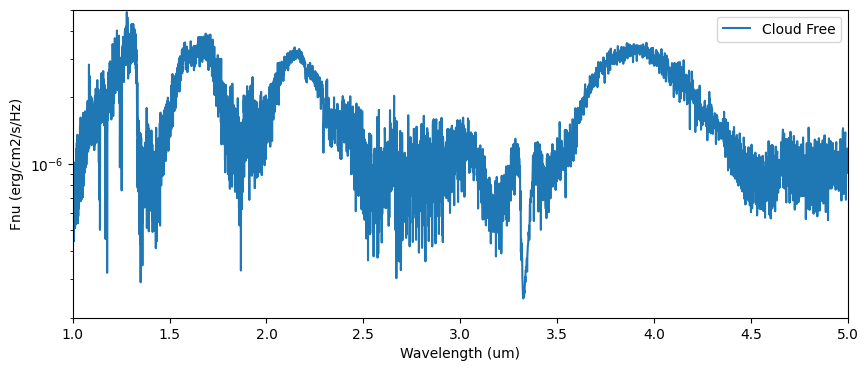

In [13]:
# show cld free spectrum
plt.figure(figsize=(10,4))
plt.plot(x_cld_free, y_cld_free, label='Cloud Free')
plt.xlim(1, 5)
plt.ylim(2e-7, 0.5e-5)
plt.yscale('log')
plt.xlabel('Wavelength (um)')
plt.ylabel('Fnu (erg/cm2/s/Hz)')
plt.legend();

In [5]:
# compute cloudy spectrum
directory = f'{ref}/virga/'
# we can get the same full output from the virga run
cld_species = ['MgSiO3', 'Mg2SiO4', "Fe"]
fseds = [1, 2, 4, 8]
cld_out = {}
for fsed in fseds:
    bd = pj.inputs(calculation='browndwarf')
    Teff = 1500
    bd.gravity(gravity=1000, gravity_unit=u.Unit('m/s**2'))
    bd.phase_angle(0)
    # prepare atmosphere pt and chemistry
    ptfile = ref + '/sonora_profile/t1500g1000f8_m0.0_co1.0.pt'
    p_callie, t_callie = np.loadtxt(ptfile, usecols=[1,2], unpack=True, skiprows=2)
    bd.add_pt(t_callie, p_callie)
    bd.channon_grid_low(filename=os.path.join(os.environ.get('picaso_refdata'),'chemistry','visscher_abunds_m+0.0_co1.0' ))
    bd.inputs['atmosphere']['profile']['kz'] = [1e9]*len(p_callie)
    bd.virga(cld_species, directory, fsed=fsed, mh=1, mmw=2.2)

    cldy = bd.spectrum(opa, full_output=True)
    x_cldy, y_cldy = convert_unit(cldy, R=3000)
    cld_out[f'fsed{fsed}'] = cldy

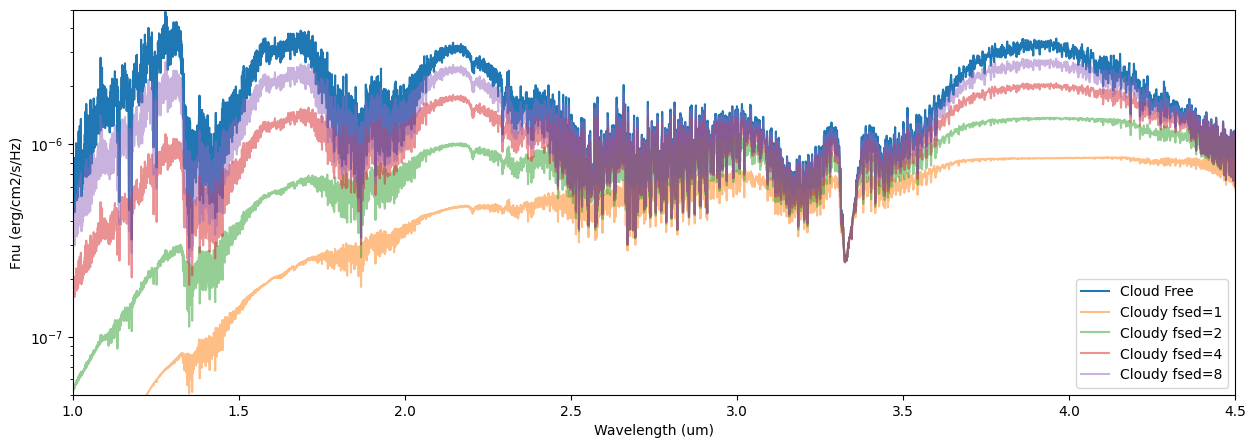

In [19]:
# show cldy spectrum
plt.figure(figsize=(15,5))
plt.plot(x_cld_free, y_cld_free, label='Cloud Free')
for fsed in fseds:
    plt.plot(cld_out[f'fsed{fsed}']['regridx'], cld_out[f'fsed{fsed}']['regridy'], 
             label=f'Cloudy fsed={fsed}', alpha=0.5)
plt.xlim(1, 4.5)
plt.ylim(0.5e-7, 0.5e-5)
plt.yscale('log')
plt.xlabel('Wavelength (um)')
plt.ylabel('Fnu (erg/cm2/s/Hz)')
plt.legend();

In [6]:
import matplotlib as mpl
def extend_colormap(cmap, end_color, factor=0.2, n=100):
    """ Extend a colormap to include a darker end color gradually.
    cmap: colormap instance, e.g., cm.OrRd
    end_color: the color to extend to, e.g., 'darkred'
    factor: proportion of the colormap to be replaced by the extended color
    n: number of colors in the new colormap
    """
    original_colors = cmap(np.linspace(0, 1, n))
    end_color_rgba = np.array(mpl.colors.to_rgba(end_color))
    
    extended_colors = []
    for i in range(n):
        if i < n * (1 - factor):
            extended_colors.append(original_colors[i])
        else:
            blend = (i - n * (1 - factor)) / (n * factor)
            blended_color = (1 - blend) * original_colors[i] + blend * end_color_rgba
            extended_colors.append(blended_color)
    
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list('extended_cmap', extended_colors)
    return new_cmap

def truncate_colormap(cmap, min_val=0.0, max_val=1.0, n=100):
    """ Truncate a colormap.
    cmap: colormap instance, e.g., cm.gist_heat
    min_val: the lower bound of the new colormap
    max_val: the upper bound of the new colormap
    n: number of colors in the new colormap
    """
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({},{:.2f},{:.2f})'.format(cmap.name, min_val, max_val),
        cmap(np.linspace(min_val, max_val, n)))
    return new_cmap

In [78]:
cfmax = 5.28e13

In [7]:
# cldy CF plot
def plot_cf(df, R=45000):
    import matplotlib.ticker as ticker
    from scipy.ndimage import gaussian_filter
    from scipy.signal import savgol_filter
    #cmap = truncate_colormap(plt.cm.OrRd, 0.0, 1) #plt.cm.gist_heat_r #Blues #gist_heat_r #hot_r
    cmap = extend_colormap(plt.cm.OrRd, (0.2, 0.0, 0.0, 1), factor=0.2)
    cmap.set_under('white',1.)
    fig, ax, CF = picplt.thermal_contribution(
        df['full_output'], norm=picplt.colors.LogNorm(vmin=1e8, vmax=1e11), tau_max=1, R=R, cmap=cmap)
        #df['full_output'], norm=picplt.colors.LogNorm(vmin=cfmax/1e3, vmax=cfmax), tau_max=1, R=R, cmap=cmap)

    y = []
    CF_scaled = np.empty_like(CF)
    for wav in np.arange(0, CF.shape[1], 1):
        y.append(p_callie[np.argmax(CF[:,wav])])
        CF_scaled[:, wav] = CF[:,wav]/np.nansum(CF[:,wav])
    x, _ = pj.mean_regrid(df['wavelength'], df['thermal'], R=R)
    y = np.array(y[::-1])
    ax.plot(x, gaussian_filter(savgol_filter(y, 101, 1), 20), '--', color='white', linewidth=1.5)
    #ax.plot(x, gaussian_filter(savgol_filter(y, 51, 1), 10), '.', color='white', markersize=0.5)

    ax.set_ylim(0.5e2, 1e-3)
    ax.set_xlim(1, 5)
    ax.set_xscale('log')
    #ax.set_xticks(np.arange(1, 6), labels=[f'{i:.1f}' for i in np.arange(1, 6)])
    ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
    ax.xaxis.set_major_formatter('{x:.1f}')
    ax.xaxis.set_tick_params(labelsize=17)
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_minor_formatter(ticker.NullFormatter())
    ax.axvspan(1.51, 1.81, alpha=0.2, color='tab:blue', label="H")
    ax.axvspan(1.95, 2.48, alpha=0.2, color='tab:blue', label="K")
    print(f'cfmax = {CF.max():.2e}')
    return CF, CF_scaled

cfmax = 5.28e+13


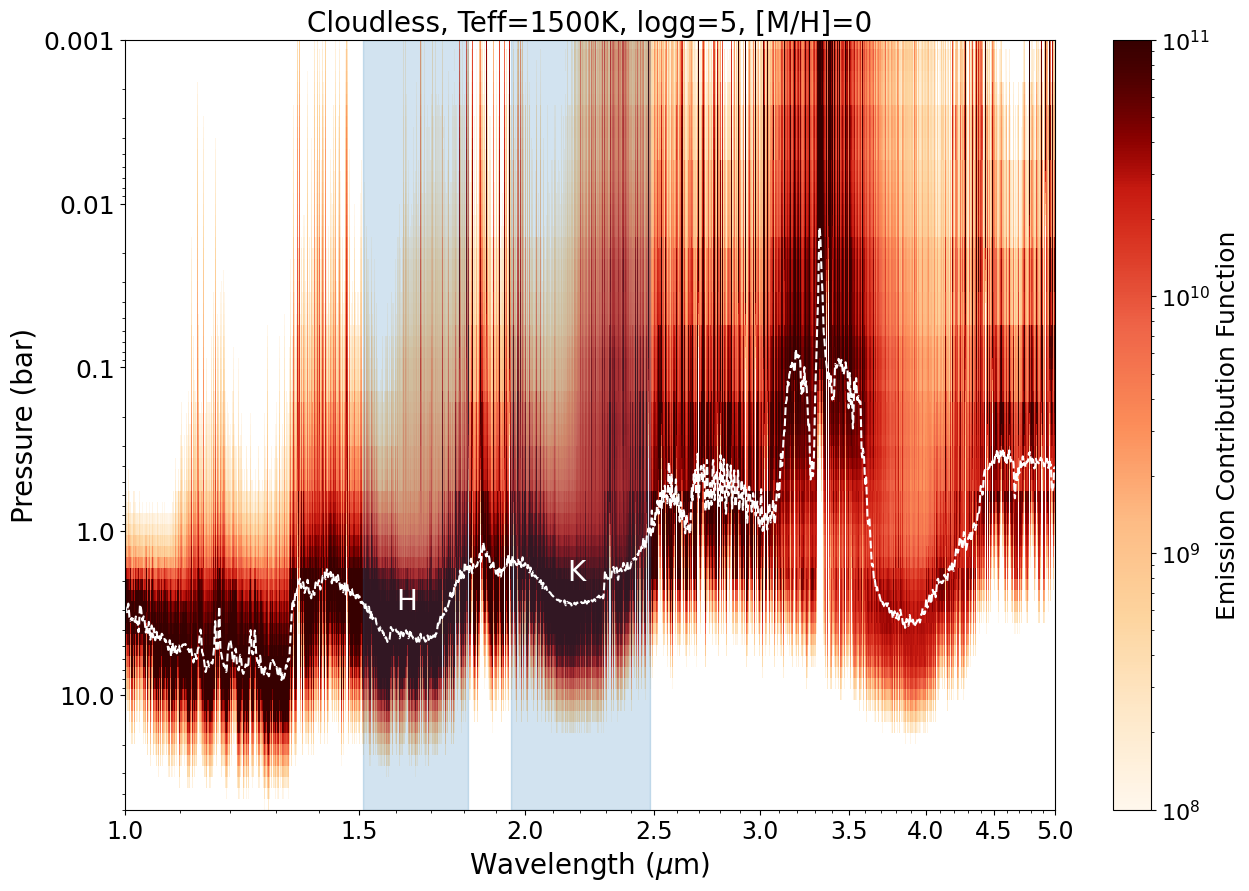

In [22]:
cf, cf_scaled = plot_cf(cld_free)
plt.text(1.6, 3., "H", color="white", fontsize=20)
plt.text(2.15, 2., "K", color="white", fontsize=20)
#plt.text(1.71, 42, "H", color="darkslategrey", fontsize=20)
#plt.text(2.36, 42, "K", color="darkslategrey", fontsize=20)
plt.title(f"Cloudless, Teff={Teff}K, logg=5, [M/H]=0", fontdict={'fontsize': 20})
plt.savefig('cf_cld_free.png', dpi=200, bbox_inches='tight', transparent=True);

cfmax = 5.28e+13


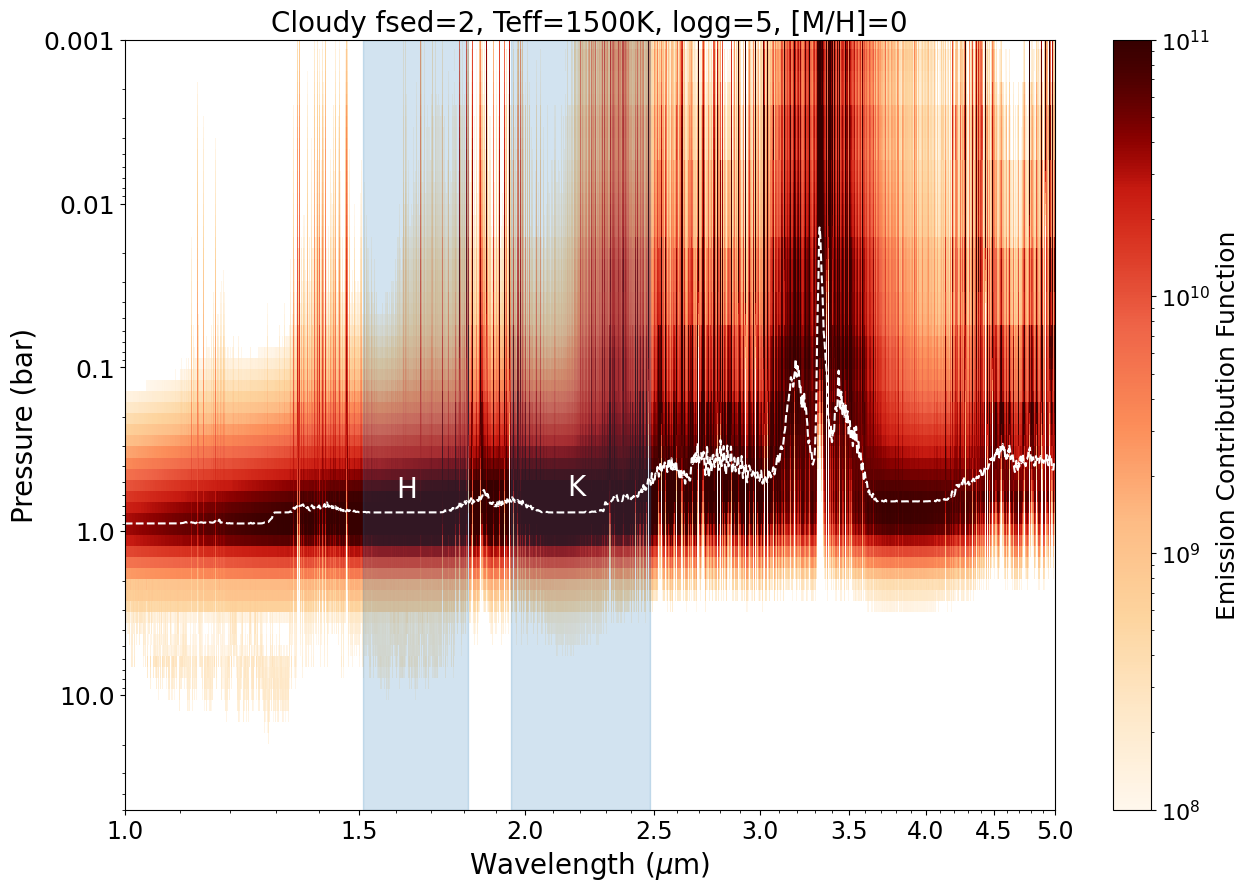

In [8]:
cf_cldy, cf_cldy_scaled = plot_cf(cld_out['fsed2'])
plt.text(1.6, 0.62, "H", color="white", fontsize=20)
plt.text(2.15, 0.6, "K", color="white", fontsize=20)
plt.title(f"Cloudy fsed=2, Teff={Teff}K, logg=5, [M/H]=0", fontdict={'fontsize': 20})
plt.savefig('cf_cldy_fsed2.png', dpi=200, bbox_inches='tight', transparent=True);

cfmax = 5.28e+13


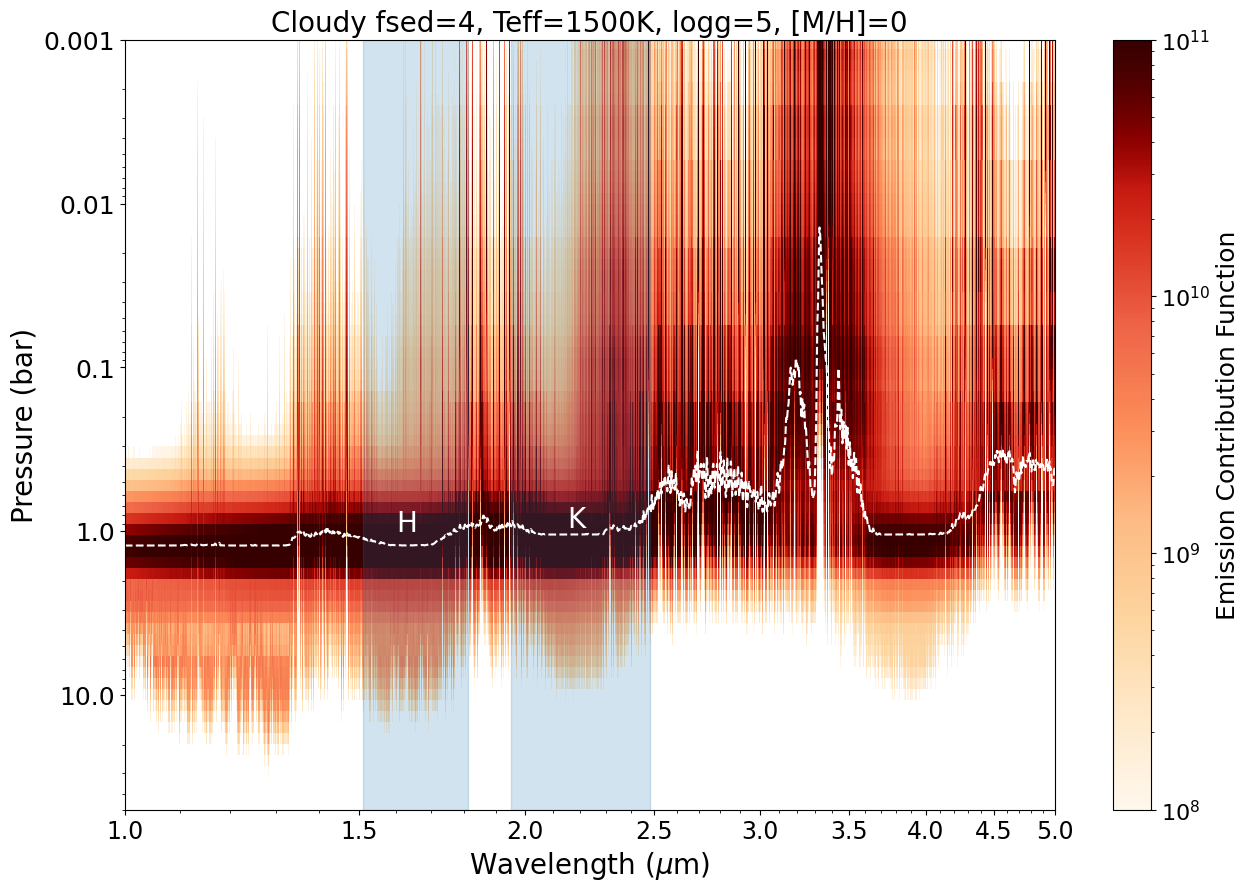

In [25]:
cf_cldy, cf_cldy_scaled = plot_cf(cld_out['fsed4'])
plt.text(1.6, 1., "H", color="white", fontsize=20)
plt.text(2.15, 0.95, "K", color="white", fontsize=20)
plt.title(f"Cloudy fsed=4, Teff={Teff}K, logg=5, [M/H]=0", fontdict={'fontsize': 20});

cfmax = 5.28e+13


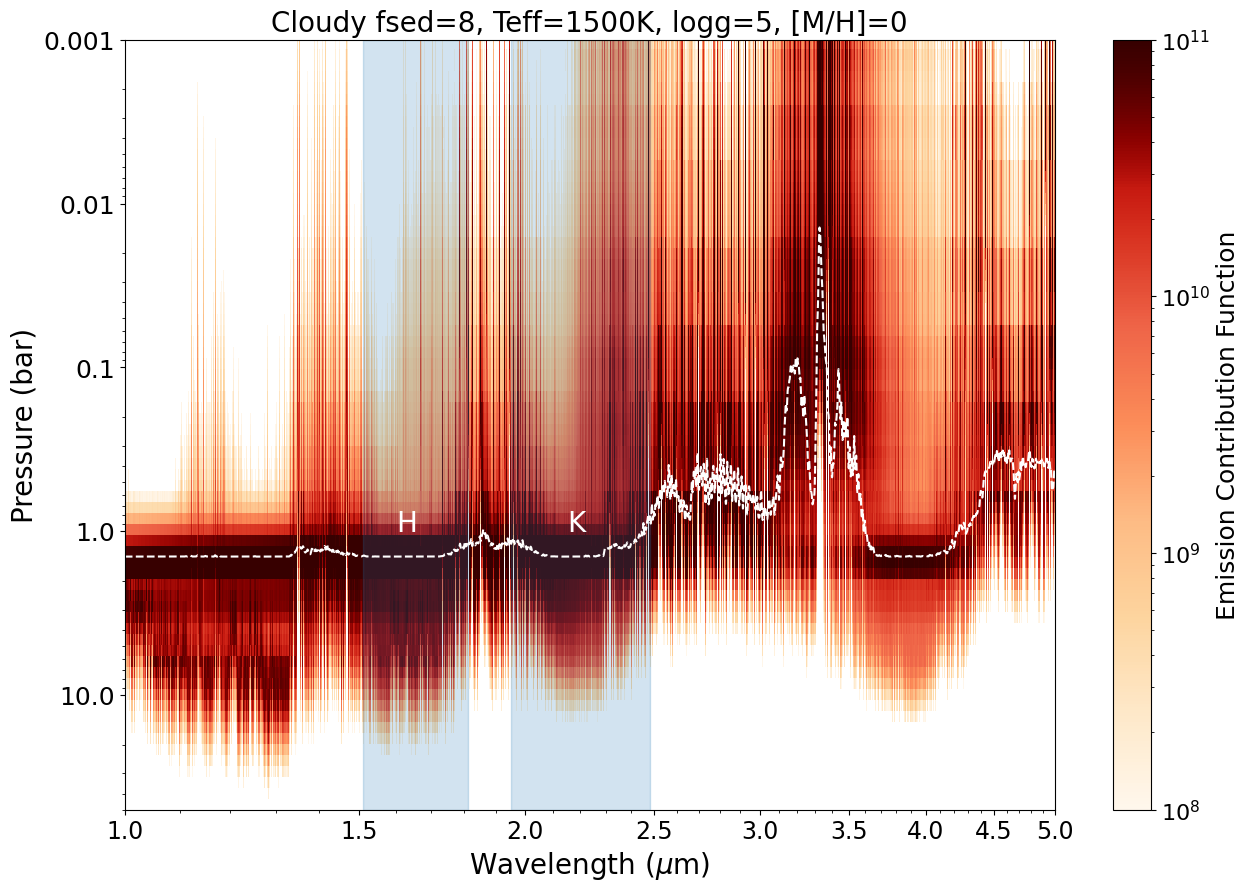

In [26]:
cf_cldy, cf_cldy_scaled = plot_cf(cld_out['fsed8'])
plt.text(1.6, 1, "H", color="white", fontsize=20)
plt.text(2.15, 1, "K", color="white", fontsize=20)
plt.title(f"Cloudy fsed=8, Teff={Teff}K, logg=5, [M/H]=0", fontdict={'fontsize': 20});

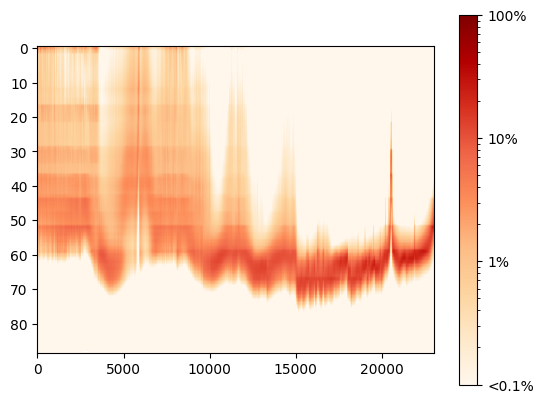

In [58]:
plt.imshow(cf_scaled, aspect=200, norm=picplt.colors.LogNorm(vmin=1e-3, vmax=1), cmap=plt.cm.OrRd)
cbar = plt.colorbar()
cbar.set_ticks([1e-3, 1e-2, 1e-1, 1])
cbar.set_ticklabels(['<0.1%', '1%', '10%', '100%'])

In [28]:
# show condensates
from bokeh.io import output_notebook
output_notebook()
recommended = vj.recommend_gas(p_callie, t_callie, metallicity, mean_molecular_weight, plot=True, height=400, width=600,)

Loading BokehJS ...

In [10]:
!pip freeze

aesara-theano-fallback==0.1.0
alabaster==0.7.16
appnope==0.1.4
arviz==0.12.1
astropy==5.3.4
asttokens==2.4.1
Babel==2.15.0
beautifulsoup4==4.12.3
bibtexparser==1.4.1
bleach==6.1.0
bokeh==2.4.3
cachetools==5.3.3
Cartopy==0.22.0
certifi==2024.7.4
cftime==1.6.4
charset-normalizer==3.3.2
colorcet==3.1.0
comm==0.2.2
contourpy==1.2.1
corner==2.2.2
cycler==0.12.1
debugpy==1.8.2
decorator==5.1.1
deprecat==2.1.1
dill==0.3.8
docutils==0.21.2
dynesty==2.1.4
emcee==3.1.0
exceptiongroup==1.2.1
executing==2.0.1
exoplanet==0.5.3
exoplanet_core==0.1.2
fastprogress==1.0.3
filelock==3.15.4
fonttools==4.53.1
h5netcdf==1.3.0
h5py==3.11.0
holoviews==1.17.1
idna==3.7
imagesize==1.4.1
importlib_metadata==8.0.0
importlib_resources==6.4.0
ipykernel==6.29.5
ipython==8.18.1
jedi==0.19.1
Jinja2==3.1.2
joblib==1.4.2
jupyter_client==8.6.2
jupyter_core==5.7.2
kiwisolver==1.4.5
llvmlite==0.43.0
Markdown==3.6
MarkupSafe==2.1.5
matplotlib==3.7.2
matplotlib-inline==0.1.7
nest-asyncio==1.6.0
netCDF4==1.6.0
numba==0.60.0
